In [42]:
import pandas as pd
import seaborn as sns
import numpy as np
import geocoder
import gmaps
import statsmodels.api as sm

import pytz

import psycopg2

from sklearn.linear_model import Ridge

import spacy

import swifter

import matplotlib.patches as mpatches

import requests


In [43]:
# Plot settings
%pylab inline

figsize(15, 9)

import matplotlib.style as style

style.use('childsafeai')

Populating the interactive namespace from numpy and matplotlib


In [44]:
from local_settings import GOOGLE_API_KEY

gmaps.configure(GOOGLE_API_KEY)

# Tests

## Processing

In [49]:
tests = requests.get("https://covidtracking.com/api/states/daily").json()
tests_df = pd.DataFrame(tests)
tests_df

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,20200404,AK,171.0,5869.0,NaN,NaN,16.0,NaN,NaN,NaN,...,16.0,6040,6040,6040,02,2.0,1.0,10.0,14.0,24.0
1,20200404,AL,1580.0,9273.0,NaN,NaN,212.0,NaN,NaN,NaN,...,212.0,10853,10853,10853,01,8.0,212.0,1086.0,148.0,1234.0
2,20200404,AR,743.0,9627.0,NaN,72.0,NaN,NaN,NaN,23.0,...,NaN,10370,10370,10370,05,2.0,0.0,632.0,39.0,671.0
3,20200404,AS,NaN,20.0,6.0,NaN,NaN,NaN,NaN,NaN,...,NaN,26,20,20,60,0.0,0.0,0.0,0.0,0.0
4,20200404,AZ,2019.0,25141.0,NaN,NaN,297.0,NaN,104.0,NaN,...,297.0,27160,27160,27160,04,11.0,48.0,2237.0,250.0,2487.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1648,20200304,OR,3.0,29.0,18.0,NaN,NaN,NaN,NaN,NaN,...,NaN,50,32,32,41,NaN,NaN,NaN,NaN,NaN
1649,20200304,SC,0.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,5,5,5,45,NaN,NaN,NaN,NaN,NaN
1650,20200304,TX,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,1,1,48,NaN,NaN,NaN,NaN,NaN
1651,20200304,WA,39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,39,39,39,53,NaN,NaN,NaN,NaN,NaN


In [46]:
tests_df['dateChecked'] = pd.to_datetime(tests_df['dateChecked'])
tests_df['Date'] = pd.to_datetime(tests_df['dateChecked'].dt.date)

In [47]:
tests_df[['positive', 'negative', 'pending', 'death', 'total']] = tests_df[['positive', 'negative', 'pending', 'death', 'total']].astype(int, errors='ignore')

In [48]:
tests_df['completed'] = tests_df['positive'] + tests_df['negative']

In [8]:
%store tests_df

Stored 'tests_df' (DataFrame)


## Analysis

In [9]:
tests_df.groupby('Date')['completed'].sum().max()

1623787.0

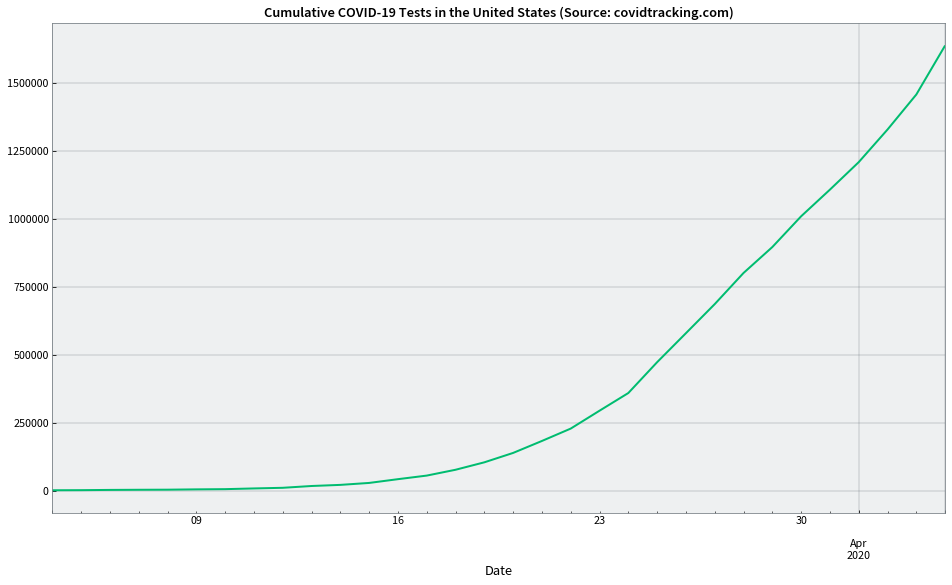

In [10]:
tests_df.groupby('Date')['total'].sum().plot(kind='line', 
                                                    title="Cumulative COVID-19 Tests in the United States (Source: covidtracking.com)")

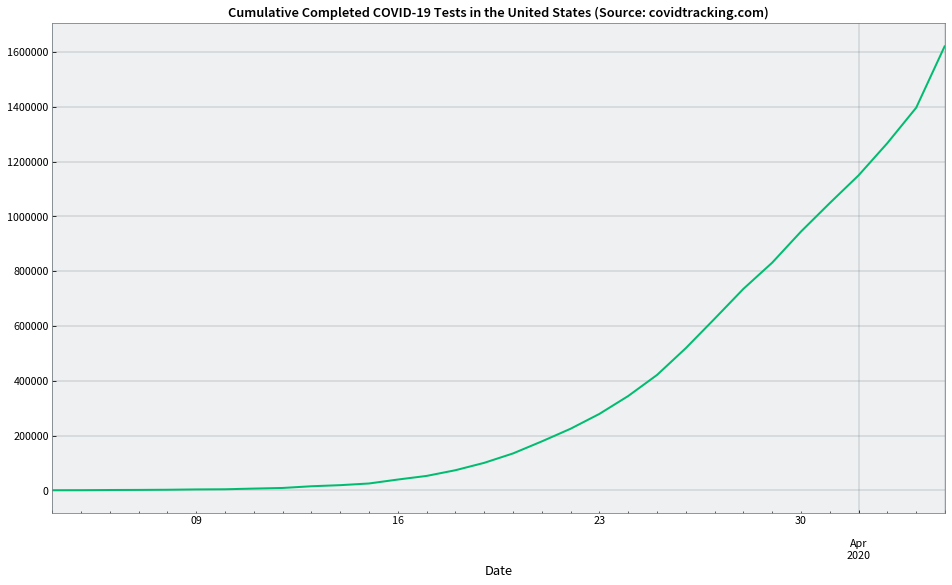

In [11]:
tests_df.groupby('Date')['completed'].sum().plot(kind='line', 
                                                    title="Cumulative Completed COVID-19 Tests in the United States (Source: covidtracking.com)")

In [12]:
tests_df

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,Date,completed
0,20200404,AK,171.0,5869.0,NaN,NaN,16.0,NaN,NaN,NaN,...,6040,6040,02,2.0,1.0,10.0,14.0,24.0,2020-04-04,6040.0
1,20200404,AL,1580.0,9273.0,NaN,NaN,212.0,NaN,NaN,NaN,...,10853,10853,01,8.0,212.0,1086.0,148.0,1234.0,2020-04-04,10853.0
2,20200404,AR,743.0,9627.0,NaN,72.0,NaN,NaN,NaN,23.0,...,10370,10370,05,2.0,0.0,632.0,39.0,671.0,2020-04-04,10370.0
3,20200404,AS,NaN,20.0,6.0,NaN,NaN,NaN,NaN,NaN,...,20,20,60,0.0,0.0,0.0,0.0,0.0,2020-04-04,NaN
4,20200404,AZ,2019.0,25141.0,NaN,NaN,297.0,NaN,104.0,NaN,...,27160,27160,04,11.0,48.0,2237.0,250.0,2487.0,2020-04-04,27160.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1648,20200304,OR,3.0,29.0,18.0,NaN,NaN,NaN,NaN,NaN,...,32,32,41,NaN,NaN,NaN,NaN,NaN,2020-03-04,32.0
1649,20200304,SC,0.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,...,5,5,45,NaN,NaN,NaN,NaN,NaN,2020-03-04,5.0
1650,20200304,TX,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,48,NaN,NaN,NaN,NaN,NaN,2020-03-04,NaN
1651,20200304,WA,39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,39,39,53,NaN,NaN,NaN,NaN,NaN,2020-03-04,NaN


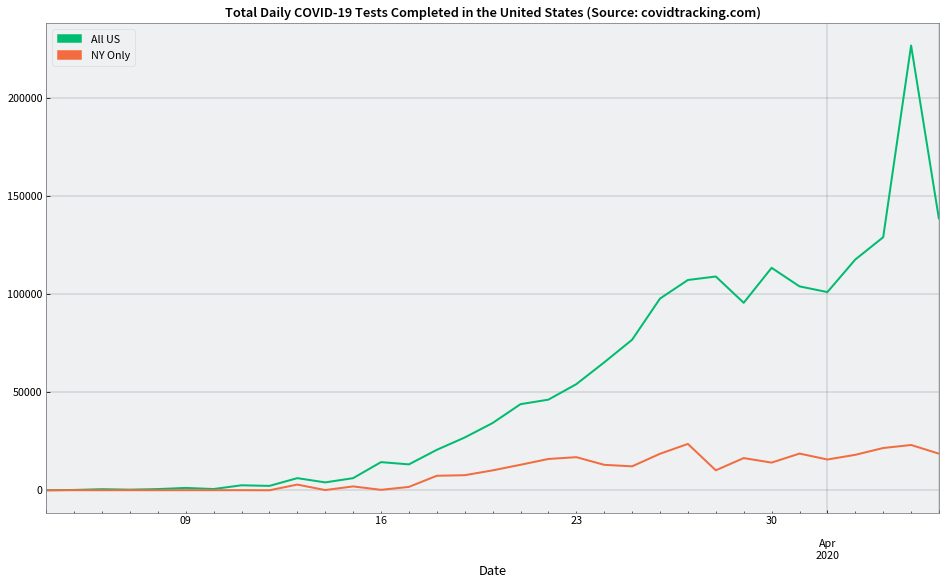

In [96]:
figsize(16, 9)
ax = tests_df.groupby('Date')['totalTestResultsIncrease'].sum().plot(kind='line', label="US",
                                                    title="Total Daily COVID-19 Tests Completed in the United States (Source: covidtracking.com)")

tests_df[tests_df['state'] == 'NY'].groupby(['Date', 'state'])['totalTestResultsIncrease'].sum().unstack('state').plot(kind='line', ax=ax)

ax.legend(handles=[mpatches.Patch(color="#00bc70", label="All US"),
                   mpatches.Patch(color="#f36c3f", label="NY Only")])

In [14]:
tests_df[tests_df['Date'] >= '2020-03-23'].groupby('Date')['total'].sum().diff().mean()

112111.33333333333

In [15]:
tests_df[(tests_df['state'] == 'NY') & (tests_df['Date'] >= '2020-03-23')].groupby('Date')['total'].sum().diff().mean()

17111.0

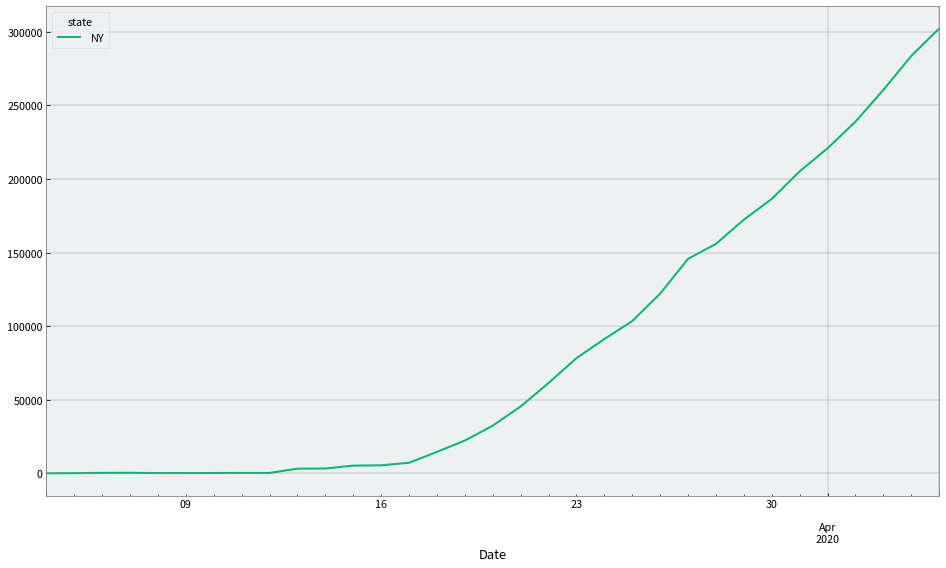

In [97]:
tests_df[tests_df['state'] == 'NY'].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line')

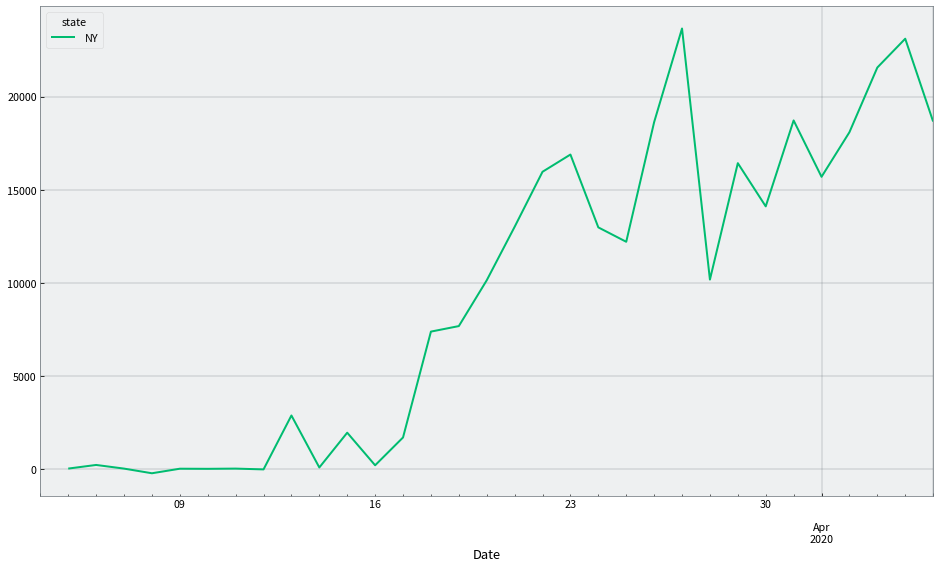

In [98]:
tests_df[tests_df['state'] == 'NY'].groupby(['Date', 'state'])['total'].max().diff().unstack('state').plot(kind='line')

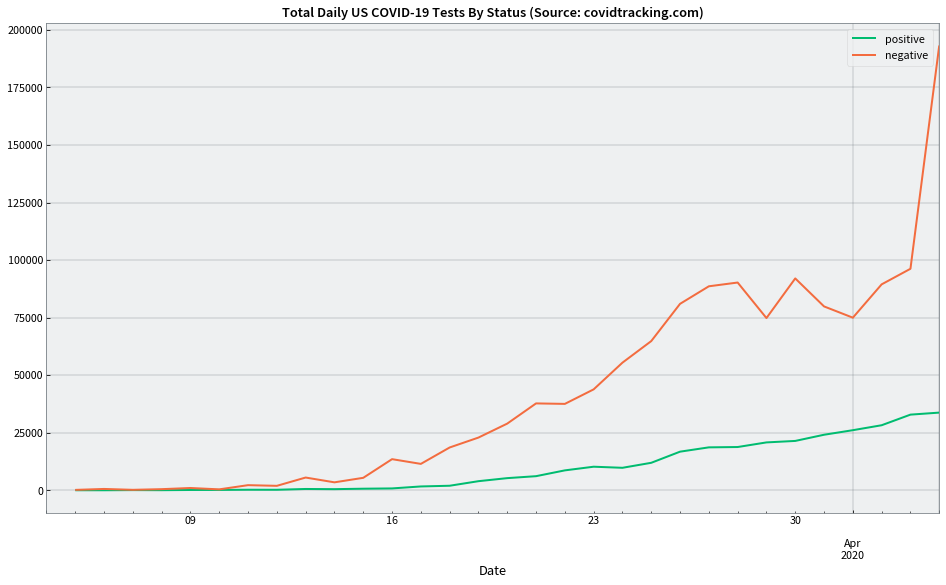

In [17]:
tests_df.groupby('Date')[['positive', 'negative']].sum().diff().plot(kind='line', 
                                                                     title="Total Daily US COVID-19 Tests By Status (Source: covidtracking.com)")

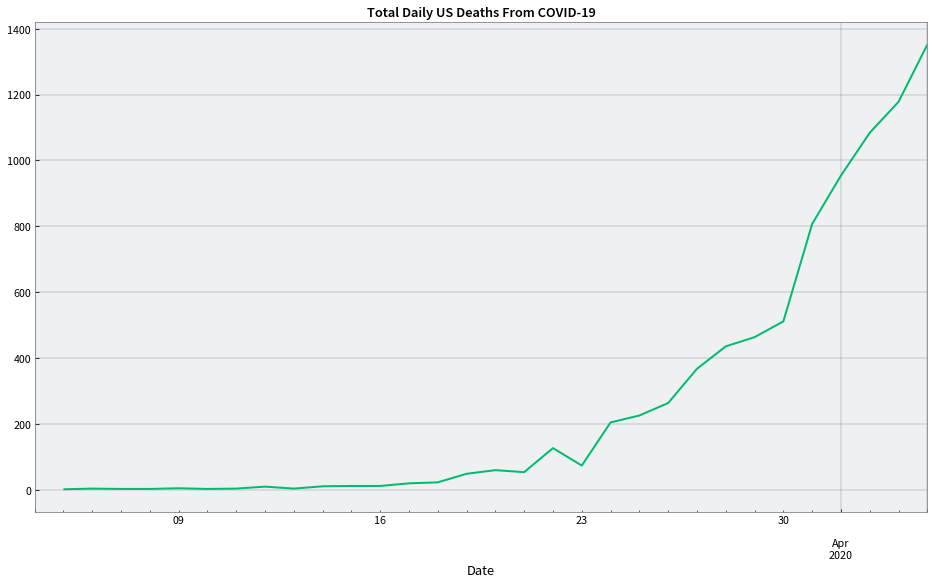

In [18]:
tests_df.groupby('Date')['death'].sum().diff().plot(kind='line',
                                                    title="Total Daily US Deaths From COVID-19")

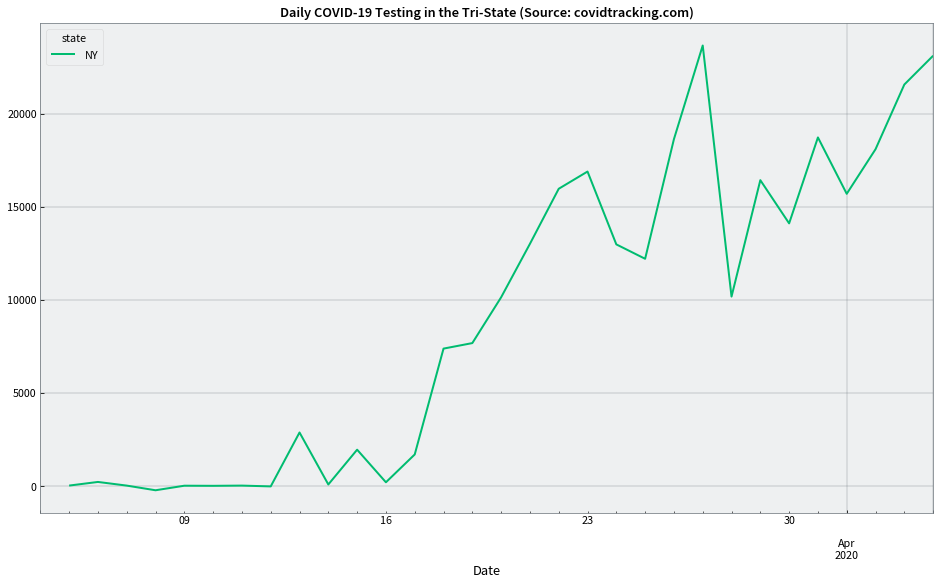

In [19]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['NY'])].groupby(['Date', 'state'])['total'].max().diff().unstack('state').plot(kind='line',
                                                                                                                     title="Daily COVID-19 Testing in the Tri-State (Source: covidtracking.com)")

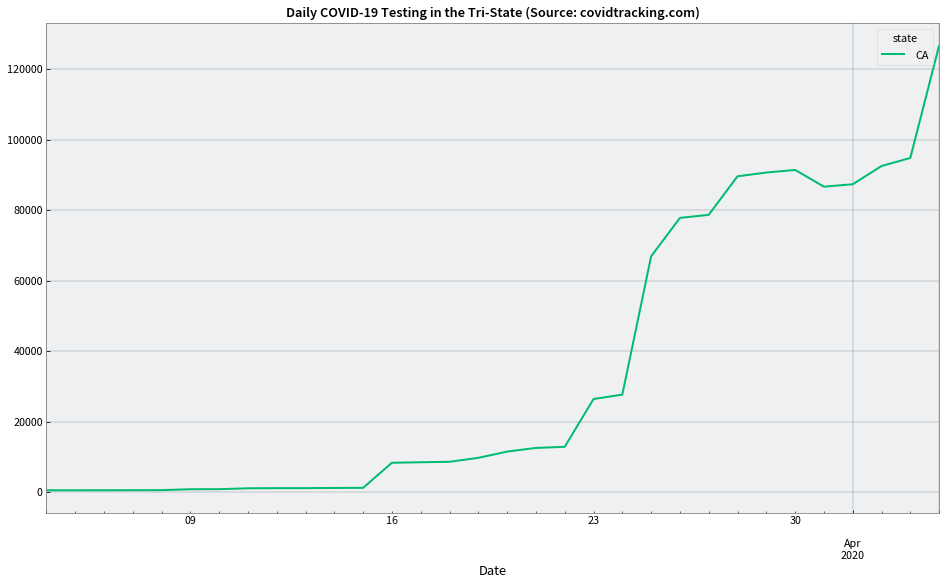

In [20]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['CA'])].groupby(['Date', 'state'])['total'].sum().unstack('state').plot(kind='line',
                                                                                                                     title="Daily COVID-19 Testing in the Tri-State (Source: covidtracking.com)")

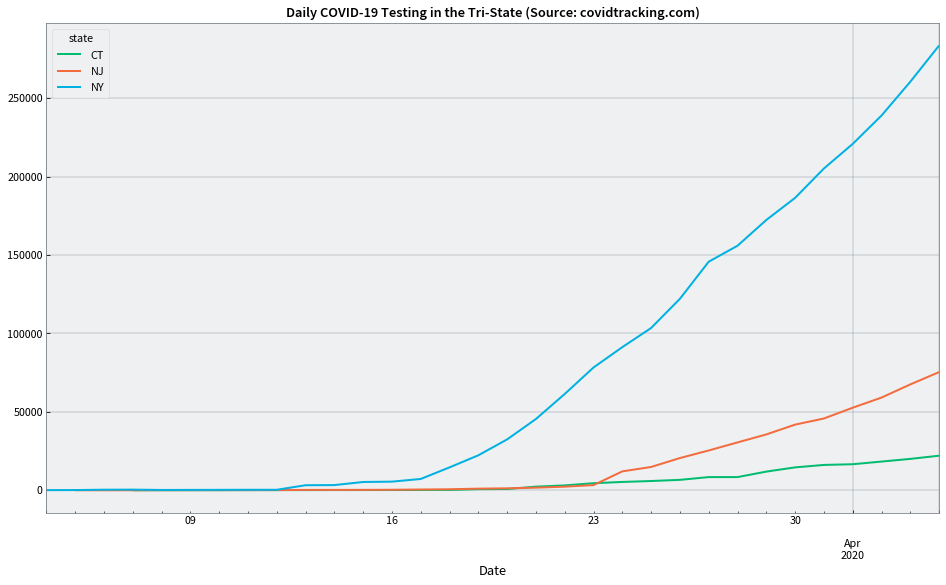

In [21]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['NY', 'CT', 'NJ'])].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line',
                                                                                                                     title="Daily COVID-19 Testing in the Tri-State (Source: covidtracking.com)")

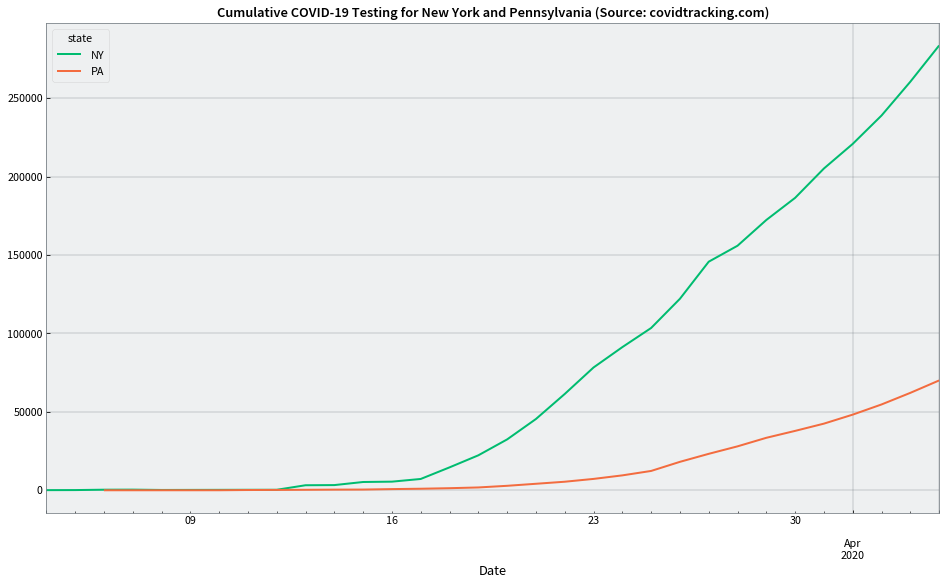

In [22]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['NY', 'PA'])].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line',
                                                                                                                     title="Cumulative COVID-19 Testing for New York and Pennsylvania (Source: covidtracking.com)")

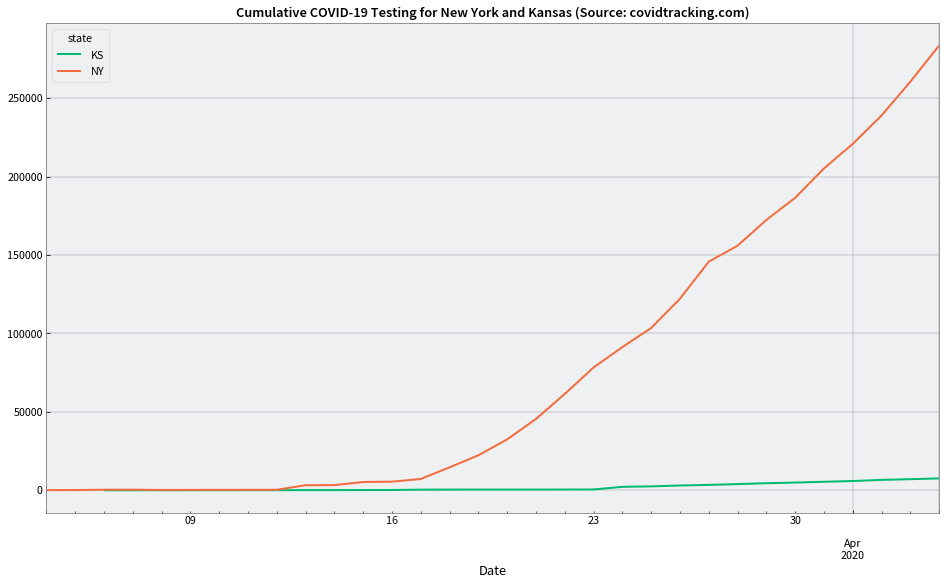

In [23]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['NY', 'KS'])].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line',
                                                                                                                     title="Cumulative COVID-19 Testing for New York and Kansas (Source: covidtracking.com)")

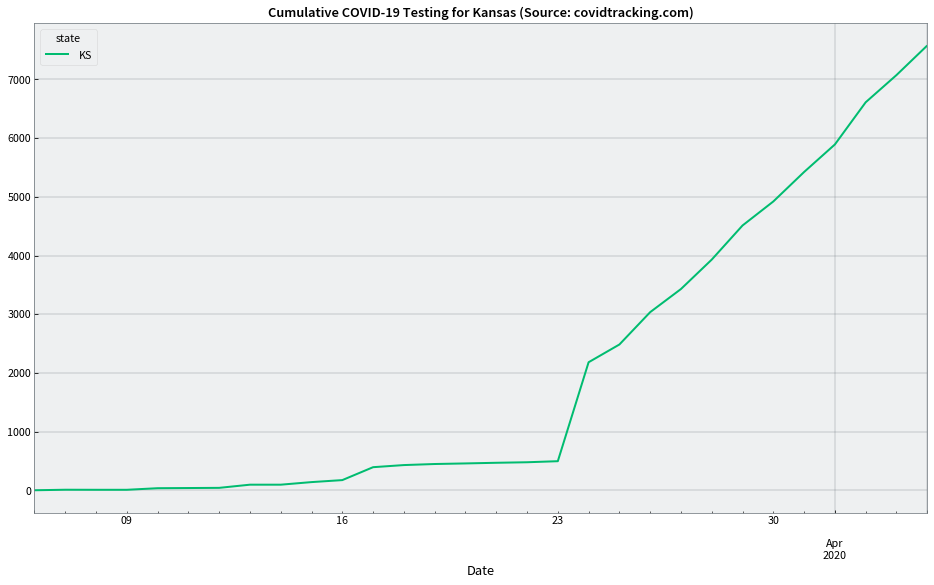

In [24]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['KS'])].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line',
                                                                                                                     title="Cumulative COVID-19 Testing for Kansas (Source: covidtracking.com)")

In [25]:
tests_df.dtypes

date                                      int64
state                                    object
positive                                float64
negative                                float64
pending                                 float64
hospitalizedCurrently                   float64
hospitalizedCumulative                  float64
inIcuCurrently                          float64
inIcuCumulative                         float64
onVentilatorCurrently                   float64
onVentilatorCumulative                  float64
recovered                               float64
hash                                     object
dateChecked                 datetime64[ns, UTC]
death                                   float64
hospitalized                            float64
total                                     int64
totalTestResults                          int64
posNeg                                    int64
fips                                     object
deathIncrease                           

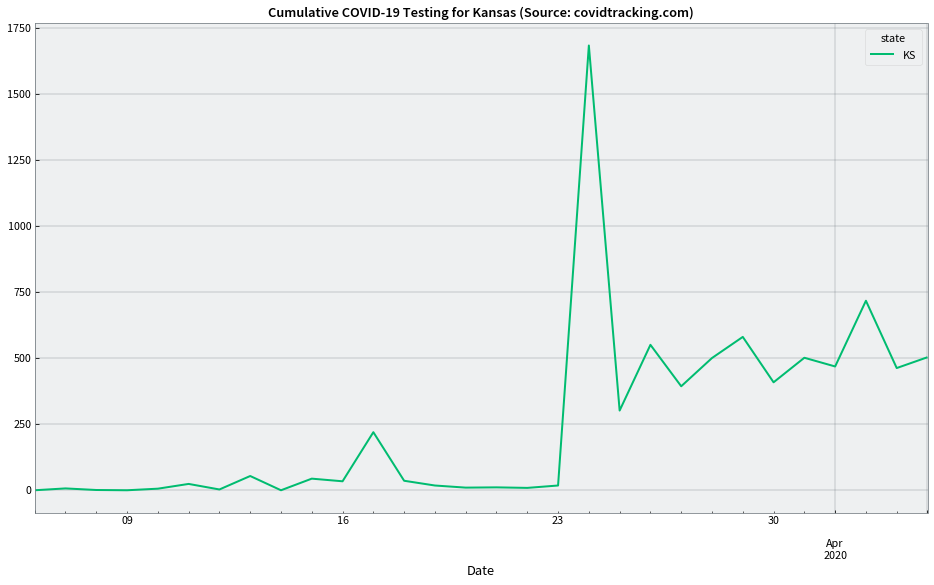

In [26]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['KS'])].groupby(['Date', 'state'])['totalTestResultsIncrease'].sum().unstack('state').plot(kind='line',
                                                                                                                     title="Cumulative COVID-19 Testing for Kansas (Source: covidtracking.com)")

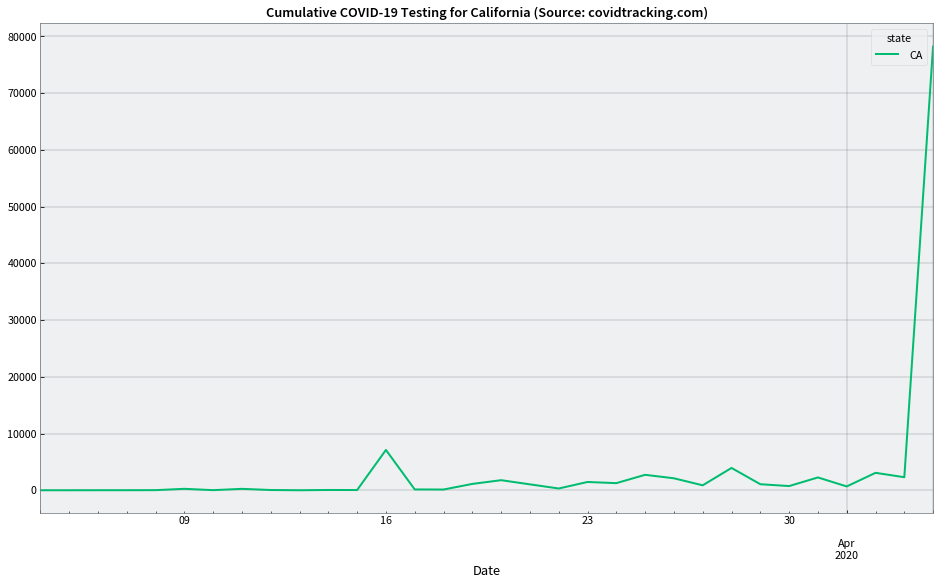

In [27]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['CA'])].groupby(['Date', 'state'])['totalTestResultsIncrease'].sum().unstack('state').plot(kind='line',
                                                                                                                     title="Cumulative COVID-19 Testing for California (Source: covidtracking.com)")

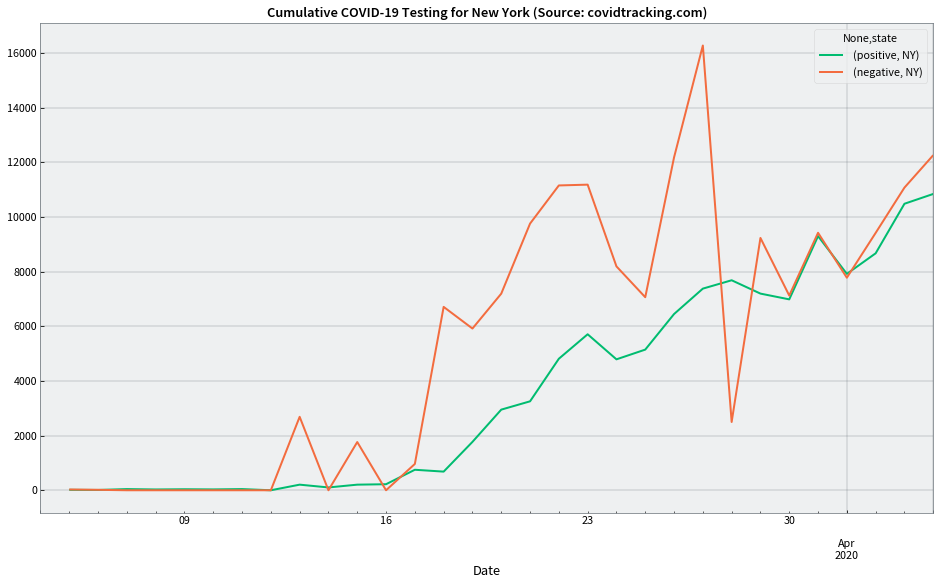

In [28]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['NY'])].groupby(['Date', 'state'])[['positive', 'negative']].max().diff().unstack('state').plot(kind='line',
                                                                                                                     title="Cumulative COVID-19 Testing for New York (Source: covidtracking.com)")

In [29]:
tests_df.dtypes

date                                      int64
state                                    object
positive                                float64
negative                                float64
pending                                 float64
hospitalizedCurrently                   float64
hospitalizedCumulative                  float64
inIcuCurrently                          float64
inIcuCumulative                         float64
onVentilatorCurrently                   float64
onVentilatorCumulative                  float64
recovered                               float64
hash                                     object
dateChecked                 datetime64[ns, UTC]
death                                   float64
hospitalized                            float64
total                                     int64
totalTestResults                          int64
posNeg                                    int64
fips                                     object
deathIncrease                           

In [30]:
((tests_df[tests_df['state'] == 'NY'].groupby('Date')['hospitalized'].max() / tests_df[tests_df['state'] == 'NY'].groupby('Date')['total'].max()) * 100)

Date
2020-03-04         NaN
2020-03-05         NaN
2020-03-06         NaN
2020-03-07         NaN
2020-03-08         NaN
2020-03-09         NaN
2020-03-10         NaN
2020-03-11         NaN
2020-03-12         NaN
2020-03-13         NaN
2020-03-14         NaN
2020-03-15         NaN
2020-03-16         NaN
2020-03-17         NaN
2020-03-18         NaN
2020-03-19         NaN
2020-03-20         NaN
2020-03-21    3.527962
2020-03-22    3.214931
2020-03-23    3.365735
2020-03-24    3.543333
2020-03-25    3.677075
2020-03-26    5.605058
2020-03-27    5.849622
2020-03-28    6.447600
2020-03-29    7.005686
2020-03-30    7.358367
2020-03-31    7.751016
2020-04-01    8.315828
2020-04-02    8.711318
2020-04-03    9.095655
2020-04-04    9.302203
dtype: float64

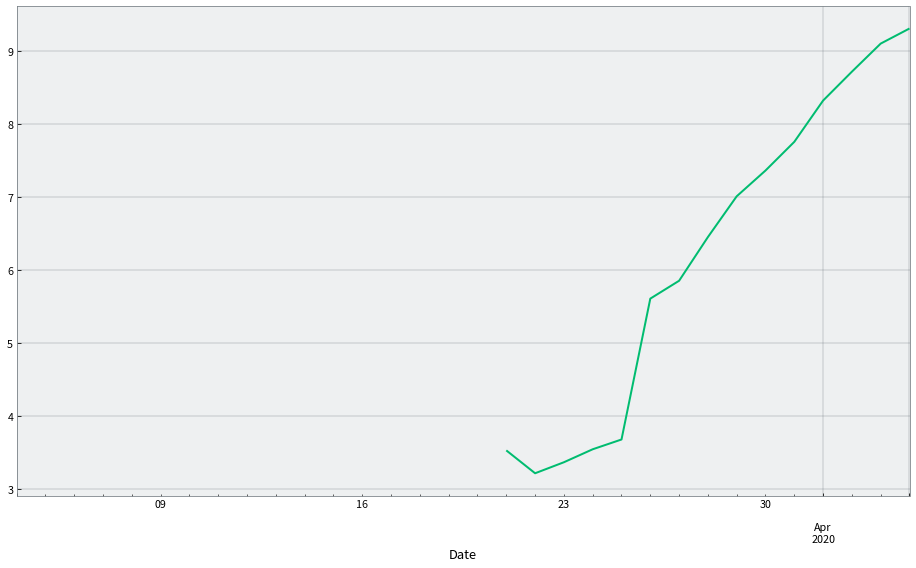

In [31]:
((tests_df[tests_df['state'] == 'NY'].groupby('Date')['hospitalized'].max() / tests_df[tests_df['state'] == 'NY'].groupby('Date')['total'].max()) * 100).plot(kind='line')

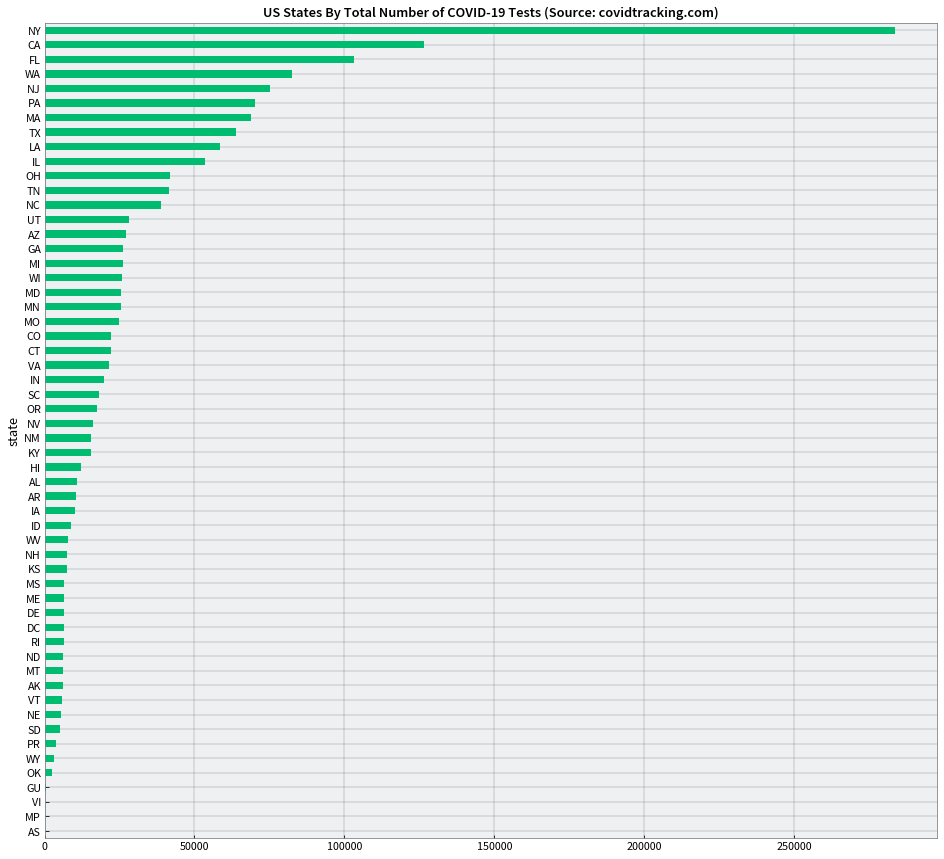

In [32]:
figsize(16,15)
tests_df.groupby('state')['total'].max().sort_values().plot(kind='barh',
                                                            title="US States By Total Number of COVID-19 Tests (Source: covidtracking.com)")

In [33]:
tests_df[tests_df['Date'] >= '2020-03-23'].groupby('state')['totalTestResultsIncrease'].mean().sort_values()

state
AS        1.538462
MP        1.615385
VI       16.769231
GU       31.692308
OK      137.307692
PR      177.769231
WY      205.384615
ME      322.384615
SD      343.307692
VT      360.461538
ND      378.384615
NE      382.692308
MT      384.615385
AK      390.153846
MS      405.153846
RI      413.461538
DC      414.076923
NH      480.923077
DE      490.384615
KS      545.923077
WV      560.692308
ID      588.692308
IA      687.307692
AL      711.615385
AR      730.307692
NM      834.846154
HI      920.538462
NV     1040.384615
KY     1077.000000
OR     1108.384615
SC     1281.000000
CO     1347.769231
VA     1401.153846
IN     1408.153846
CT     1456.076923
WI     1488.923077
MN     1595.615385
GA     1713.384615
MI     1770.307692
UT     1873.384615
MO     1880.461538
MD     1944.000000
AZ     2055.846154
NC     2487.307692
TN     2893.384615
OH     3183.076923
IL     3481.615385
TX     4230.384615
LA     4230.769231
WA     4267.538462
MA     4822.692308
PA     4968.230769
NJ    

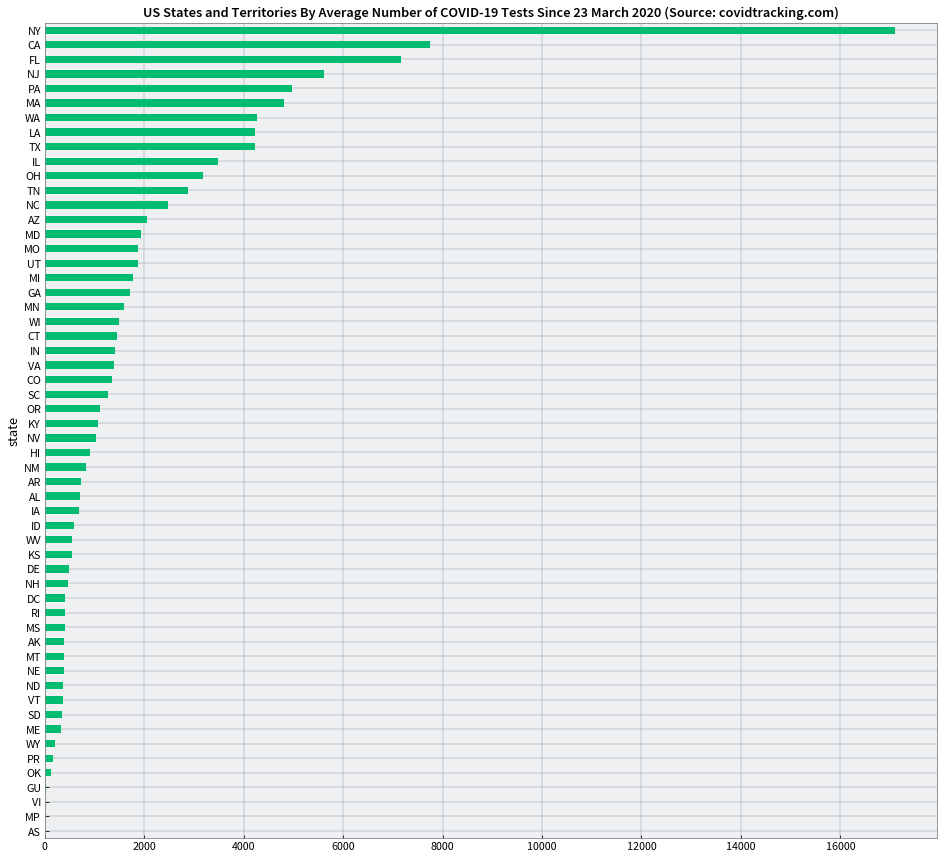

In [34]:
tests_df[tests_df['Date'] >= '2020-03-23'].groupby('state')['totalTestResultsIncrease'].mean().sort_values().plot(kind='barh',
                                                                                                                  title="US States and Territories By Average Number of COVID-19 Tests Since 23 March 2020 (Source: covidtracking.com)")

In [41]:
tests_df.groupby('state')['positive'].max().sort_values()

state
AS         0.0
MP         8.0
VI        40.0
GU        93.0
AK       171.0
ND       186.0
WY       187.0
SD       212.0
MT       265.0
WV       282.0
HI       319.0
NE       321.0
PR       452.0
ME       456.0
VT       461.0
NM       495.0
NH       540.0
DE       593.0
KS       698.0
AR       743.0
IA       786.0
RI       806.0
KY       831.0
MN       865.0
OR       899.0
DC       902.0
ID      1013.0
OK      1159.0
UT      1428.0
MS      1455.0
AL      1580.0
NV      1742.0
SC      1917.0
AZ      2019.0
WI      2112.0
MO      2291.0
NC      2402.0
VA      2407.0
MD      3125.0
TN      3321.0
OH      3739.0
IN      3953.0
CO      4173.0
CT      5276.0
TX      6110.0
GA      6160.0
WA      6966.0
PA     10017.0
IL     10357.0
FL     11111.0
MA     11736.0
CA     12026.0
LA     12496.0
MI     14225.0
NJ     34124.0
NY    113704.0
Name: positive, dtype: float64

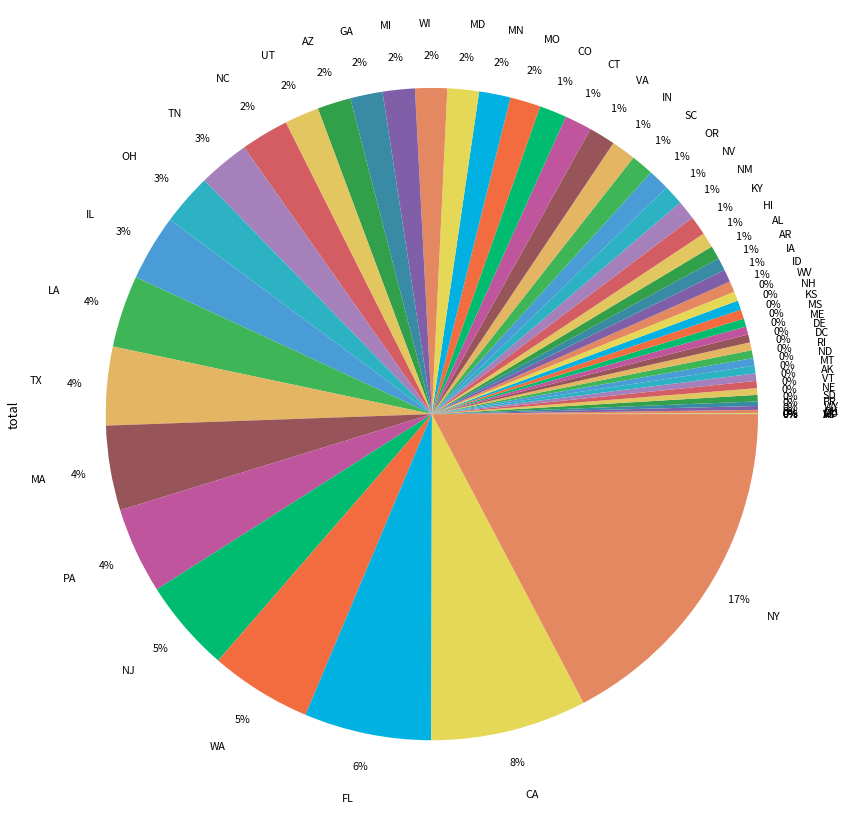

In [36]:
tests_df.groupby('state')['total'].max().sort_values().plot(kind='pie', autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2, legend=False,)

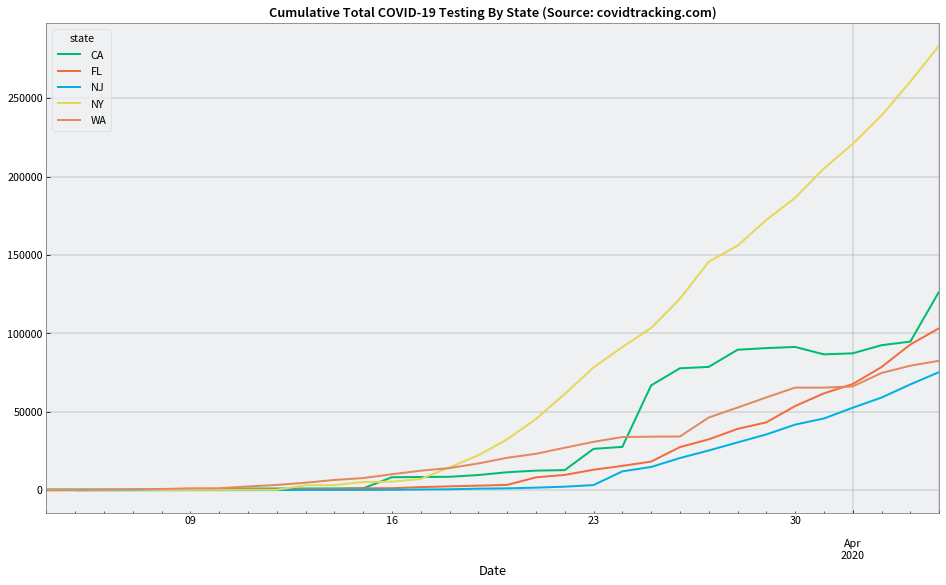

In [37]:
figsize(16, 9)
tests_df[tests_df['state'].isin(tests_df.groupby('state')['total'].max().sort_values()[-5:].index)].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line',
                                                                                                                                                                     title="Cumulative Total COVID-19 Testing By State (Source: covidtracking.com)")

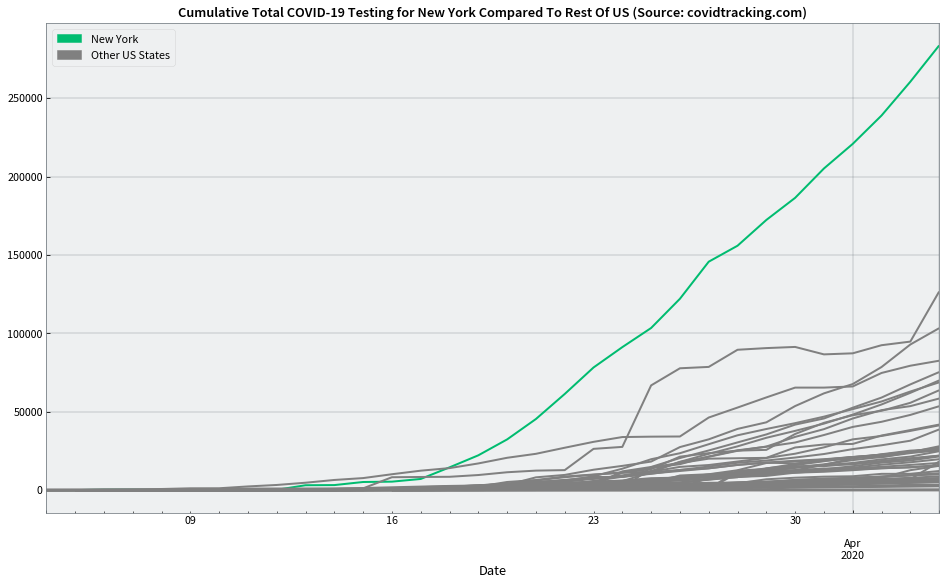

In [38]:


figsize(16, 9)
ax = tests_df[tests_df['state'] == 'NY'].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line',
                                                                                                         title="Cumulative Total COVID-19 Testing for New York Compared To Rest Of US (Source: covidtracking.com)")

tests_df[-(tests_df['state'] == 'NY')].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line',
                                                                                                       color="gray",
                                                                                                       legend=False,
                                                                                                       ax=ax)

patch = mpatches.Patch(color="gray", label="Other US States")
ax.legend(handles=[mpatches.Patch(color="#00bc70", label="New York"),
                   mpatches.Patch(color="gray", label="Other US States")])

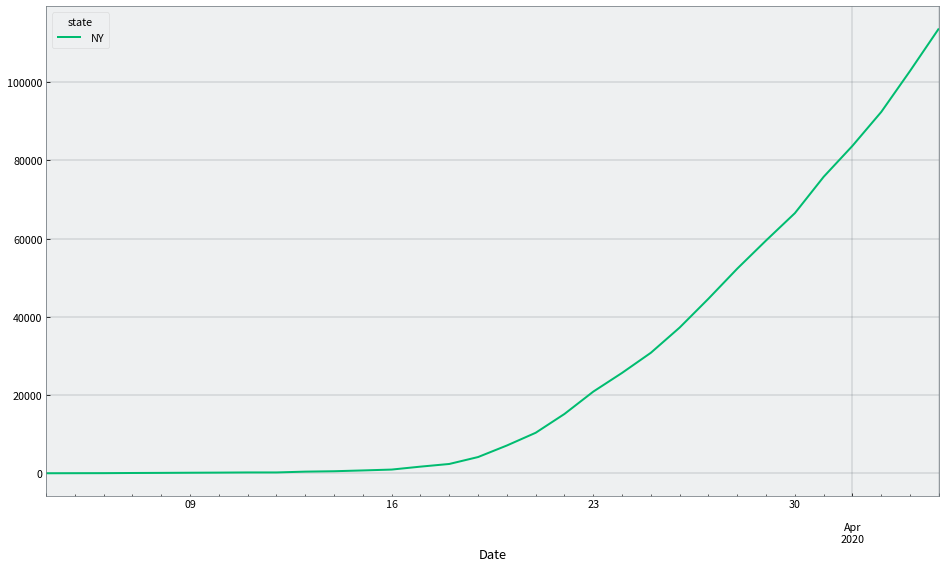

In [39]:
ax = tests_df[tests_df['state'] == 'NY'].groupby(['Date', 'state'])['positive'].max().unstack('state').plot(kind='line', color="#00bc70", label="Positive COVID-19 Tests")

In [40]:
ny_state_hospitalization['Cumulative Hospitalized'] = 

SyntaxError: invalid syntax (<ipython-input-40-cc48b835a970>, line 1)

In [ ]:
tests_df['New York?'] = tests_df['state'].str.contains('NY')

In [ ]:
ax = tests_df[tests_df['Date'] == '2020-03-22'].groupby('New York?')['total'].sum().plot(kind='pie', autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2, legend=False,
                                                       title="Distribution of COVID-19 Testing - New York vs. Rest of the United States (Source: covidtracking.com)",
                                                       labels=['Rest of US', 'New York'])

In [ ]:
tests_df[tests_df['Date'] == '2020-03-22'].groupby('New York?')['total'].sum()

In [ ]:
tests_df.groupby(['Date', 'New York?'])['total'].sum().unstack('New York?').diff()